In [ ]:
from simulator import TerminationPolicy, Simulator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from scipy import stats

In [2]:
# SETTINGS
SEED = 42
WARMUP = False
warmup_events = 500
lambda_ = 1  # arrival_rate
mu = 1.5  # service_rate

os.makedirs("results", exist_ok=True) if not os.path.exists("results") else None
csv_name = (
    f"mm1_{lambda_}_{mu}_warmup.csv" if WARMUP else f"mm1_{lambda_}_{mu}_nowarmup.csv"
)
path_to_csv = os.getcwd() + f"/results/{csv_name}.csv"

# delete the file if it exists
if os.path.exists(path_to_csv):
    os.remove(path_to_csv)

# Setup and run the simulator

In [3]:
# Termination policy: stop when the simulation time reaches 1,000 time units
policy = (
    TerminationPolicy()
    .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= int(1e3))
    .all()
)

# Run the simulation
print(f"Running simulation with arrival rate: {lambda_}, service rate: {mu}")
sim = Simulator(
    arrival_rate=lambda_, service_rate=mu, seed=SEED, path_to_csv=path_to_csv
)
sim.run(termination_condition=policy)
sim.report()

Running simulation with arrival rate: 1, service rate: 1.5
Arrivals: 928
Departures: 926
Final queue length: 1
Server busy: True
Total Arrivals: 928
Total Services: 926


# Plots of Utilization and packets in the system

In [4]:
# Load the simulation results from the CSV file
data = pd.read_csv(path_to_csv)

if WARMUP:
    # remove first warmup_events
    data = data.iloc[warmup_events:]

# compute total packets in the system (queue + 1 if busy, else queue)
data["total_current_packets"] = data["queue_length"] + data["server_busy"].astype(int)

ro = lambda_ / mu
# Theoretical average number of packets in the system (stationary regime)
t_packet_mean = (
    ro / (1 - ro) if ro < 1 else np.inf
)  # if arrival rate >= service rate, the system is unstable (it saturates)

print(
    f"Average number of packets in the system: {data['total_current_packets'].mean():.4f} (theoretical: {t_packet_mean:.4f})"
)
# compute the average utilization
data["delta_t"] = data["time"].shift(-1) - data["time"]
data["delta_t"] = data["delta_t"].fillna(0.0)  # put to zero last value


data["cumulative_busy_time"] = (data["server_busy"] * data["delta_t"]).cumsum()
data["elapsed_time"] = data["time"] - data["time"].iloc[0]

data["cumulative_utilization"] = data["cumulative_busy_time"] / data["elapsed_time"]
data["cumulative_utilization"] = data["cumulative_utilization"].fillna(
    0.0
)  ##fill the Nan in first row

emp_util_mean = data["cumulative_utilization"].iloc[-1]

print(f"Utilization: {emp_util_mean:.4f} (theoretical: {lambda_ / mu:.4f})")

Average number of packets in the system: 1.9941 (theoretical: 2.0000)
Utilization: 0.5983 (theoretical: 0.6667)


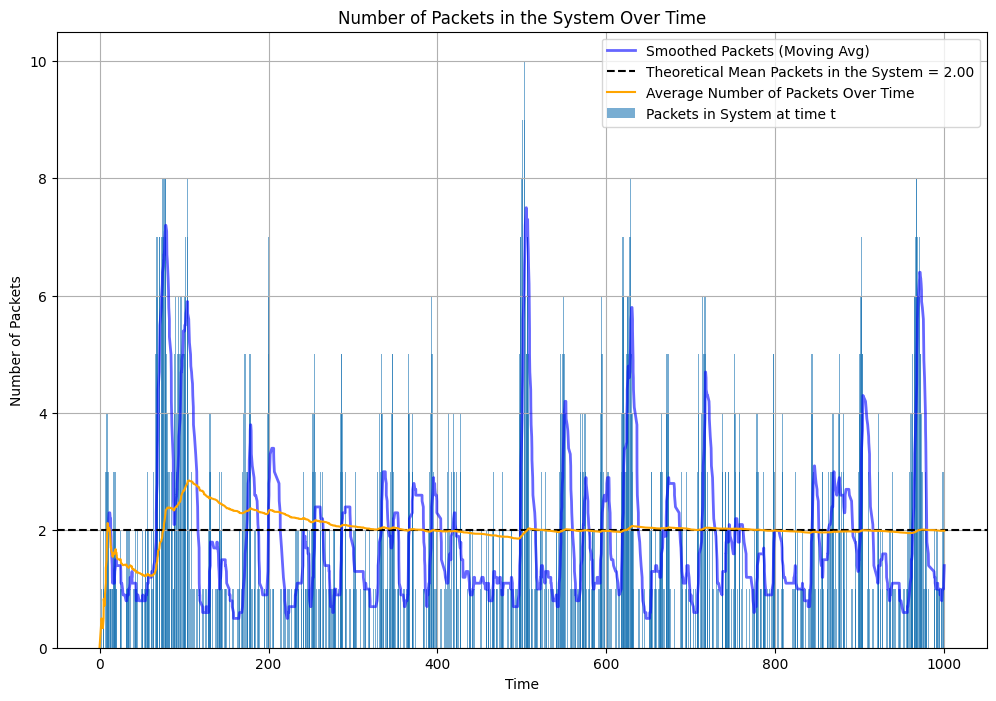

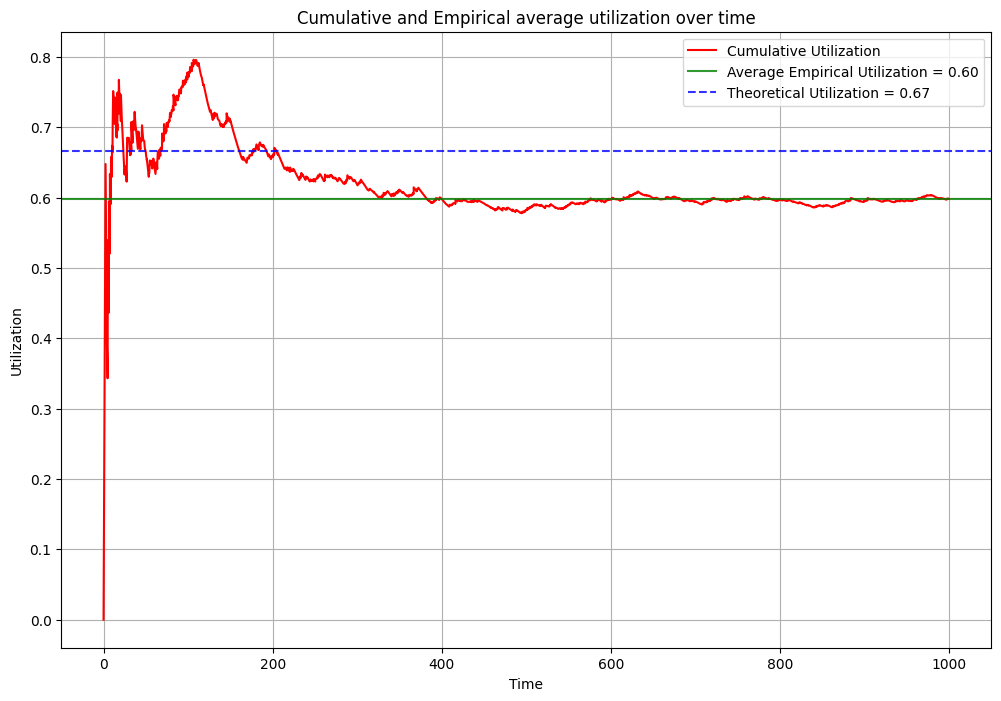

In [ ]:
# Plot the number of packets in the system over time
plt.figure(figsize=(12, 8))
data["smoothed_packets"] = data["total_current_packets"].rolling(window=20).mean()
plt.plot(
    data["time"],
    data["smoothed_packets"],
    color="blue",
    label="Smoothed Packets (Moving Avg)",
    linewidth=2,
    alpha=0.6,
)
plt.bar(
    data["time"],
    data["total_current_packets"],
    label="Packets in System at time t",
    alpha=0.6,
)
plt.axhline(
    y=t_packet_mean,
    color="black",
    linestyle="--",
    label=f"Theoretical Mean Packets in the System = {t_packet_mean:.2f}",
)
plt.plot(
    data["time"],
    data["total_current_packets"].expanding().mean(),
    color="orange",
    label="Average Number of Packets Over Time",
)
plt.xlabel("Time")
plt.ylabel("Number of Packets")
plt.title("Number of Packets in the System Over Time")
plt.legend()
plt.grid()

plt.figure(figsize=(12, 8))
plt.plot(
    data["time"],
    data["cumulative_utilization"],
    label="Cumulative Utilization",
    color="red",
)
plt.axhline(
    emp_util_mean,
    color="green",
    label=f"Average Empirical Utilization = {emp_util_mean:.2f}",
    alpha=0.8,
)
plt.axhline(
    ro,
    color="blue",
    linestyle="--",
    label=f"Theoretical Utilization = {ro:.2f}",
    alpha=0.8,
)
plt.xlabel("Time")
plt.ylabel("Utilization")
plt.title("Cumulative and Empirical average utilization over time")
plt.legend()
plt.grid()
plt.show()

# Running simulation batches to assess the behavior of the system with different parameters

In [ ]:
lamda_values = [0.5, 1.0, 1.5]
mu_values = [0.5, 1.0, 1.5]

NUM_REPLICATIONS = 10
NUM_TIME_UNITS = 1000

seeds = range(SEED, SEED + NUM_REPLICATIONS)

policy = (
    TerminationPolicy()
    .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= NUM_TIME_UNITS)
    .all()
)

# prepare to collect CSV paths
sim_results = []

# run simulations (unchanged)
for lambda_ in lamda_values:
    for mu in mu_values:
        for rep in range(NUM_REPLICATIONS):
            seed = seeds[rep]
            csv_name = f"mm1_{lambda_}_{mu}_rep_{rep}"
            path_to_csv = os.path.join(os.getcwd(), "results", f"{csv_name}.csv")
            # Store metadata
            sim_results.append(
                {"lambda": lambda_, "mu": mu, "replication": rep, "path": path_to_csv}
            )

            sim = Simulator(
                arrival_rate=lambda_,
                service_rate=mu,
                seed=seed,
                path_to_csv=path_to_csv,
            )
            sim.run(termination_condition=policy)

In [ ]:
# Define a common time grid
grid = np.arange(0, NUM_TIME_UNITS + 1)  # integer times

# Group CSV results by (lambda, mu)
grouped_results = {}
for entry in sim_results:
    key = (entry["lambda"], entry["mu"])
    if key not in grouped_results:
        grouped_results[key] = []
    grouped_results[key].append(entry["path"])

# Store averaged utilization curves for each (lambda, mu) pair
avg_utilizations = {}

for (lambda_, mu), paths in grouped_results.items():
    all_utilization = np.zeros((len(paths), grid.size))

    for i, csv_file in enumerate(paths):
        data = pd.read_csv(csv_file)

        # Compute delta_t, cumulative_busy_time, elapsed_time
        data["delta_t"] = data["time"].shift(-1) - data["time"]
        data.loc[data.index[-1], "delta_t"] = 0.0

        data["cumulative_busy_time"] = (
            data["server_busy"].astype(int) * data["delta_t"]
        ).cumsum()
        data["elapsed_time"] = data["time"] - data["time"].iloc[0]

        # Compute utilization, avoid divide-by-zero
        utilization = np.where(
            data["elapsed_time"] > 0,
            data["cumulative_busy_time"] / data["elapsed_time"],
            0.0,
        )

        # Interpolate onto the fixed grid
        all_utilization[i, :] = np.interp(grid, data["time"].values, utilization)

    # Compute average utilization for this (lambda, mu) group
    mean_utilization = all_utilization.mean(axis=0)
    avg_utilizations[(lambda_, mu)] = mean_utilization

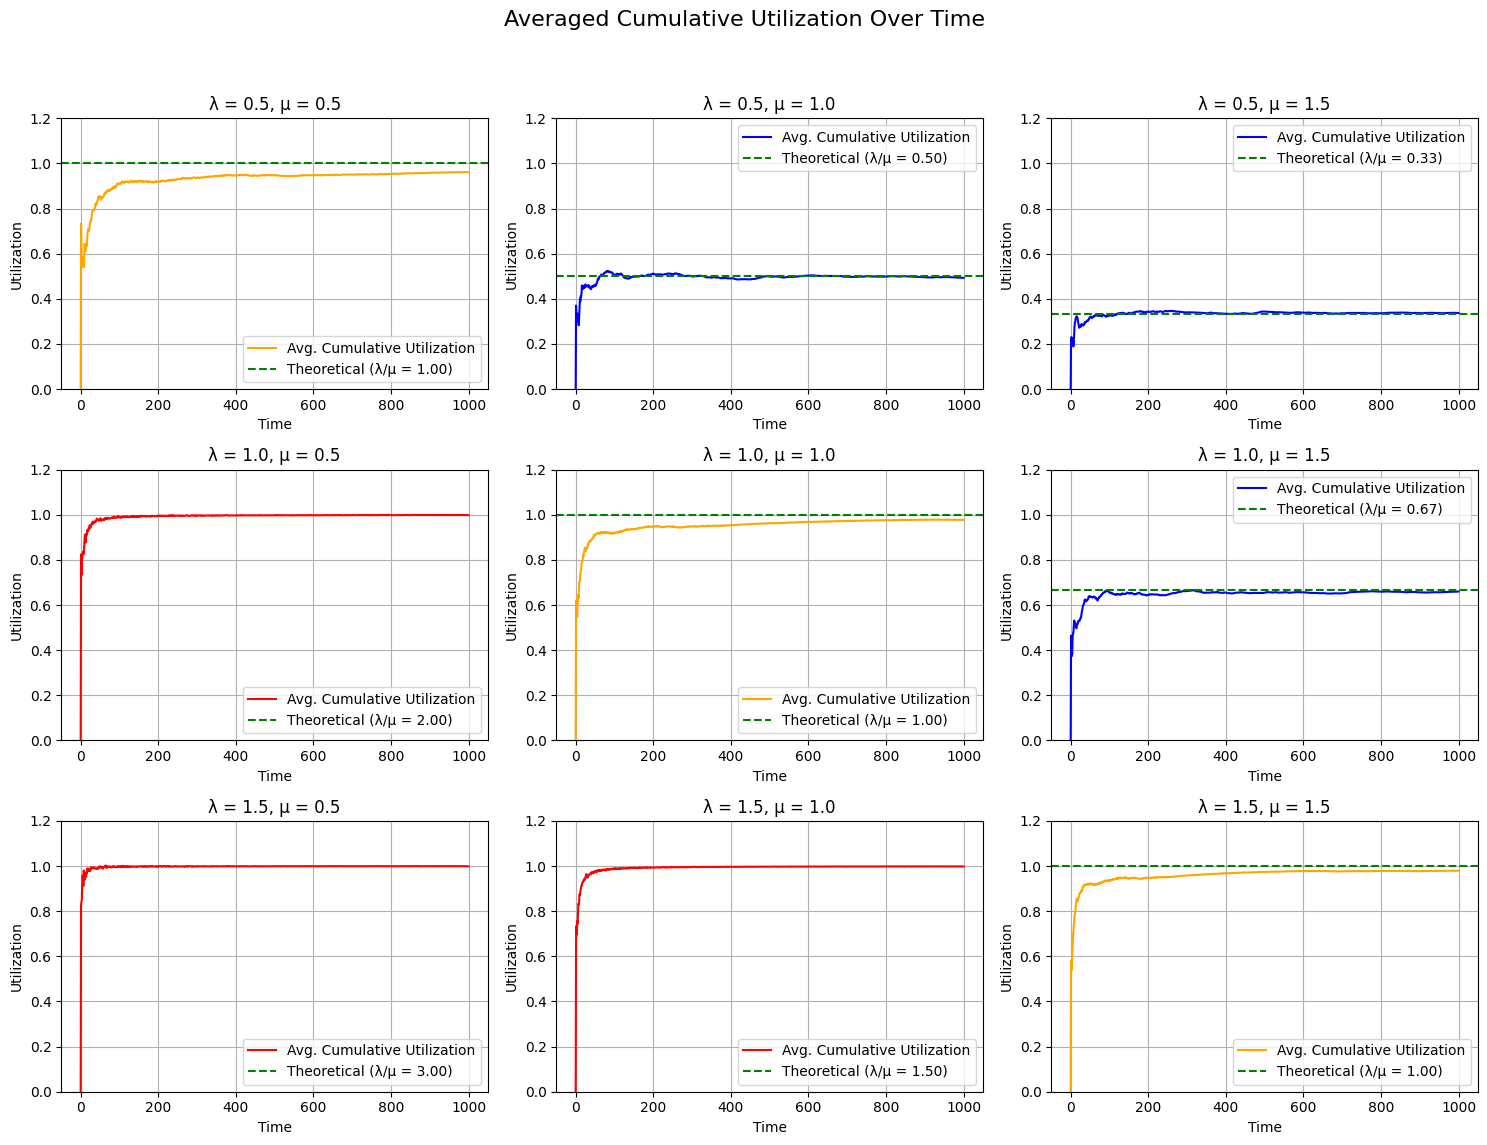

In [ ]:
# Determine the grid size for subplots
num_plots = len(avg_utilizations)
cols = 3  # Choose how many columns you want
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Plot each utilization curve in a subplot
for idx, ((lambda_, mu), utilization_curve) in enumerate(avg_utilizations.items()):
    row, col = divmod(idx, cols)
    ax = axes[row][col]

    color = "blue" if mu > lambda_ else "red" if mu < lambda_ else "orange"

    theoretical_util = lambda_ / mu

    ax.plot(grid, utilization_curve, color=color, label="Avg. Cumulative Utilization")
    ax.axhline(
        theoretical_util,
        color="green",
        linestyle="--",
        label=f"Theoretical (λ/μ = {theoretical_util:.2f})",
    )
    ax.set_ylim(0, 1.2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Utilization")
    ax.set_title(f"λ = {lambda_}, μ = {mu}")
    ax.grid()
    ax.legend()

fig.suptitle("Averaged Cumulative Utilization Over Time", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

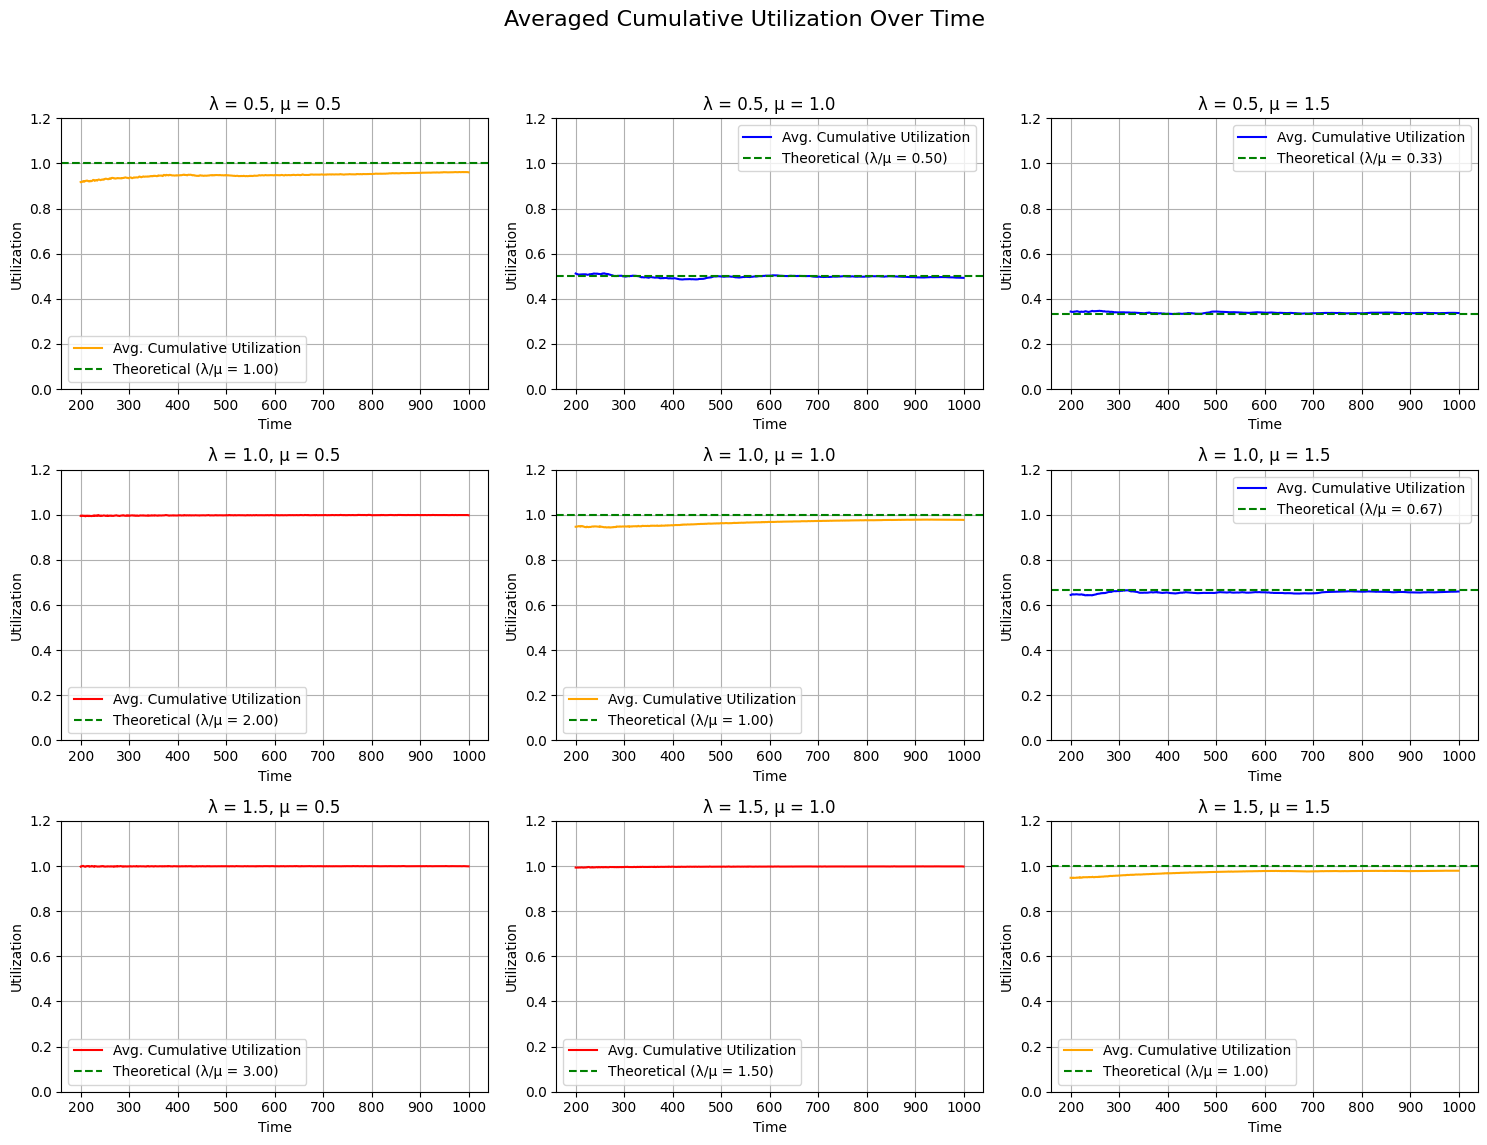

In [71]:
# Drop the first events
NUM_DROPPED_EVENTS = 200

truncated_utils = {}
for (lambda_, mu), utilization_curve in avg_utilizations.items():
    # Truncate the first NUM_DROPPED_EVENTS points
    truncated_utils[(lambda_, mu)] = utilization_curve[NUM_DROPPED_EVENTS:]

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Plot each utilization curve in a subplot
for idx, ((lambda_, mu), utilization_curve) in enumerate(truncated_utils.items()):
    row, col = divmod(idx, cols)
    ax = axes[row][col]

    color = "blue" if mu > lambda_ else "red" if mu < lambda_ else "orange"

    theoretical_util = lambda_ / mu

    ax.plot(
        grid[NUM_DROPPED_EVENTS:],
        utilization_curve,
        color=color,
        label="Avg. Cumulative Utilization",
    )
    ax.axhline(
        theoretical_util,
        color="green",
        linestyle="--",
        label=f"Theoretical (λ/μ = {theoretical_util:.2f})",
    )
    ax.set_ylim(0, 1.2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Utilization")
    ax.set_title(f"λ = {lambda_}, μ = {mu}")
    ax.grid()
    ax.legend()

fig.suptitle("Averaged Cumulative Utilization Over Time", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
summary_rows = []

for (lambda_, mu), paths in grouped_results.items():
    per_rep_utils = []

    for path in paths:
        data = pd.read_csv(path)

        # 1) drop the first NUM_DROPPED_EVENTS rows
        data = data.iloc[NUM_DROPPED_EVENTS:].reset_index(drop=True)

        # 2) recompute delta_t and total busy time
        data["delta_t"] = data["time"].shift(-1) - data["time"]
        data.loc[data.index[-1], "delta_t"] = 0.0

        busy_time = (data["server_busy"].astype(int) * data["delta_t"]).sum()
        total_time = data["time"].iloc[-1] - data["time"].iloc[0]

        # 3) per-replication utilization
        per_rep_utils.append(busy_time / total_time)

    # convert to numpy array for stats
    utils = np.array(per_rep_utils)
    n = len(utils)
    mean_u = utils.mean()
    var_u = utils.var(ddof=1)  # sample variance
    se_u = np.sqrt(var_u / n)

    # 95% CI using Student’s t
    ci_low, ci_high = stats.t.interval(0.95, df=n - 1, loc=mean_u, scale=se_u)

    # collect
    summary_rows.append(
        {
            "lambda": lambda_,
            "mu": mu,
            "n_reps": n,
            "mean_util": mean_u,
            "var_util": var_u,
            "ci95_lo": ci_low,
            "ci95_hi": ci_high,
            "theoretical": lambda_ / mu,
        }
    )

# turn into a DataFrame
summary_df = pd.DataFrame(summary_rows)

/home/simone/uni/spe/SPE-labs/.venv/lib64/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simone/uni/spe/SPE-labs/.venv/lib64/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


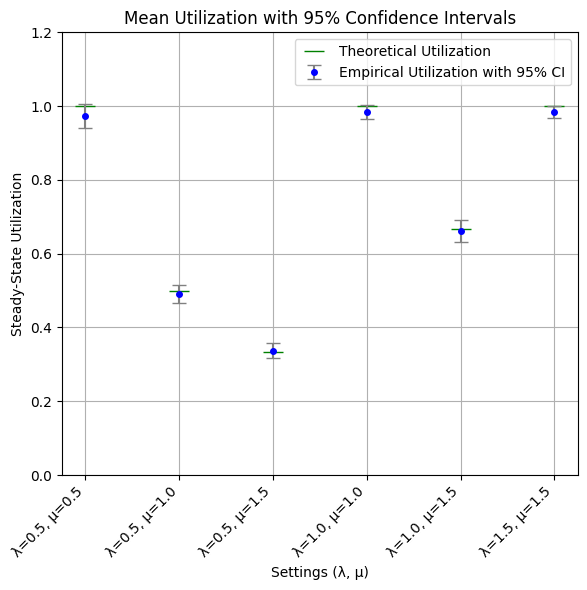

In [ ]:
# Filter out rows where lambda is greater than mu
filtered_df = summary_df[summary_df["lambda"] <= summary_df["mu"]]

# Create labels
labels = [
    f"λ={lam}, μ={mu}" for lam, mu in zip(filtered_df["lambda"], filtered_df["mu"])
]
x = np.arange(len(labels))

# Compute error bars (asymmetrical)
y = filtered_df["mean_util"]
yerr = [y - filtered_df["ci95_lo"], filtered_df["ci95_hi"] - y]

# Plot
plt.figure(figsize=(6, 6))
plt.plot(
    x, filtered_df["theoretical"], "g_", markersize=15, label="Theoretical Utilization"
)
plt.errorbar(
    x,
    y,
    yerr=yerr,
    fmt="o",
    capsize=5,
    markersize=4,
    color="blue",
    ecolor="gray",
    label="Empirical Utilization with 95% CI",
)

plt.xticks(x, labels, rotation=45, ha="right")
plt.ylim(0, 1.2)
plt.ylabel("Steady-State Utilization")
plt.xlabel("Settings (λ, μ)")
plt.title("Mean Utilization with 95% Confidence Intervals")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()